# Predicting Death in MIMIC3

## Data Loading

In [1]:
from numpy.random import seed
seed(2)

import os
import sys
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report

In [241]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam

In [3]:
df = pd.read_csv(os.path.join('../mimic/data_processed', 'mimic_dataset_incomplete.csv'))

In [4]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'M').astype(int)

In [5]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [7]:
# sanity check
df_test['HADM_ID'].isin(df_train['HADM_ID']).value_counts()

False    2844
Name: HADM_ID, dtype: int64

In [8]:
df_train['HADM_ID'].isin(df_test['HADM_ID']).value_counts()

False    12412
Name: HADM_ID, dtype: int64

In [9]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2'
]

In [10]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        maxshape = max(maxshape, point.values.shape)
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [12]:
X_train.shape

(2312, 63, 16)

## Dataset

### Histogram of Days

Don't cut to 14 days - want last day data before death for now

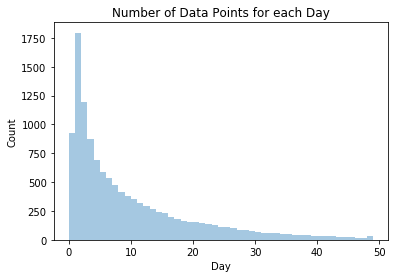

In [13]:
fig = sns.distplot(df_train[df_train.Day < 50]['Day'], bins=range(50), kde=False)
plt.title('Number of Data Points for each Day')
plt.ylabel('Count')
plt.show(fig)

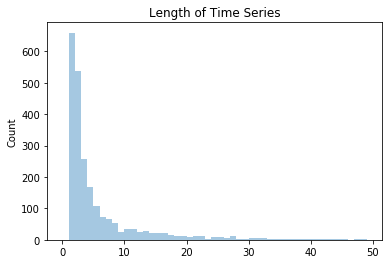

In [14]:
fig = sns.distplot([len(x) for x in lst_train if len(x) <= 50], bins=range(50), kde=False)
plt.title('Length of Time Series')
plt.ylabel('Count')
plt.show(fig)

In [15]:
# summary statistics
df_train['Day'].describe()

count    12412.000000
mean        10.494521
std         13.320318
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        131.000000
Name: Day, dtype: float64

In [16]:
# number of patients who died
df_train.groupby('HADM_ID').first()['DEATH'].value_counts()

0    1576
1     736
Name: DEATH, dtype: int64

In [17]:
1 - sum(Y_test) / len(Y_test)

0.707105719237435

In [18]:
# class weights
class_weight = {0: 1, 1: 2}

### Histogram of Outcomes for Each Feature
We want to see the distributions for each different numeric feature. This is best done as a histogram. You can see all of these histograms below.

HCO3, Age and Heart Rate appear to be the most separable. 

In [19]:
def plot_feature(col):
    died = []
    discharged = []

    for index, point in enumerate(lst_train):        
        if Y_train[index]:
            died.append(point[0, X_cols.index(col)])
        else:
            discharged.append(point[0, X_cols.index(col)])

    minimum = int(min(*died,*discharged))
    maximum = int(max(*died,*discharged))
    
    if minimum == 0 and maximum == 1:
        return
            
    sns.distplot(discharged, kde=False, bins=range(minimum, maximum), label="Discharged")
    fig = sns.distplot(died, kde=False, bins=range(minimum, maximum), label="Died")
    plt.title(f'Histogram for {col.title()}')
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    plt.show(fig)

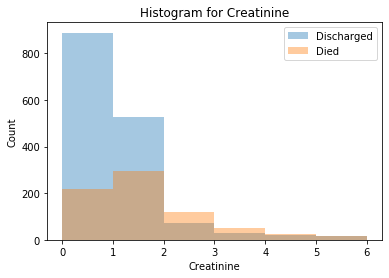

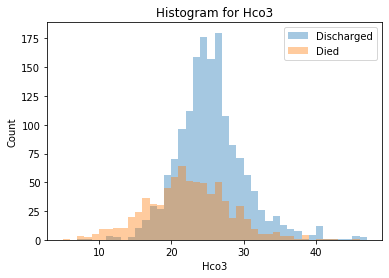

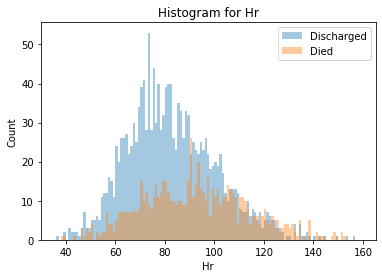

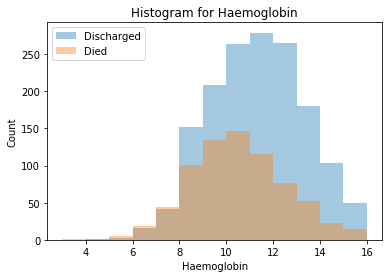

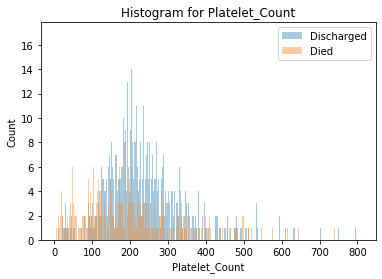

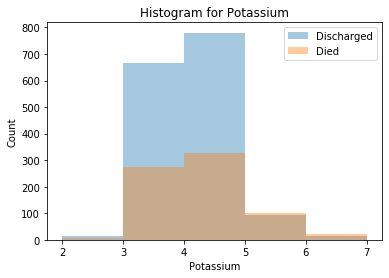

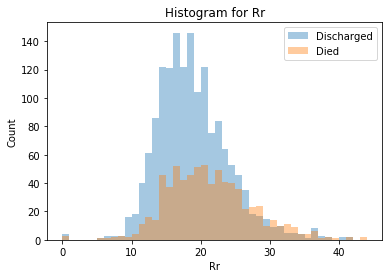

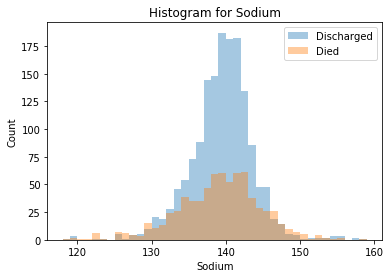

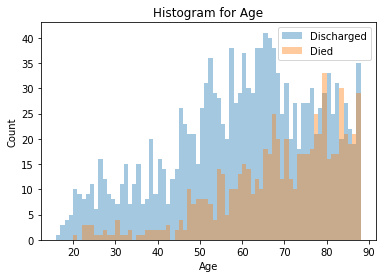

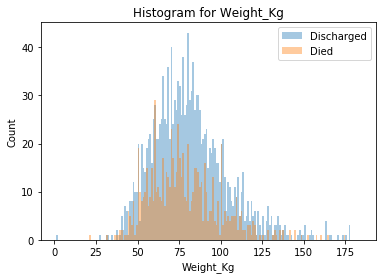

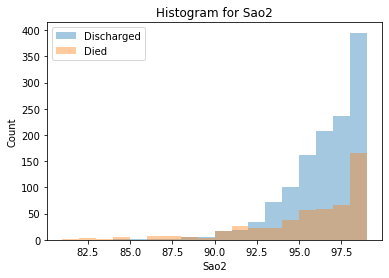

In [20]:
for col in X_cols:
    plot_feature(col)

### Histogram of Outcomes for each day

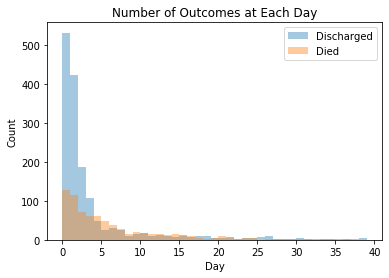

In [21]:
died = []
discharged = []

for index, point in enumerate(lst_train):
    if len(point) - 1 > 40:
        continue
        
    if Y_train[index]:
        died.append(len(point) - 1)
    else:
        discharged.append(len(point) - 1)
    
sns.distplot(discharged, kde=False, bins=range(40), label="Discharged")
fig = sns.distplot(died, kde=False, bins=range(40), label="Died")
plt.title('Number of Outcomes at Each Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.legend()
plt.show(fig)

### Correlation matrix

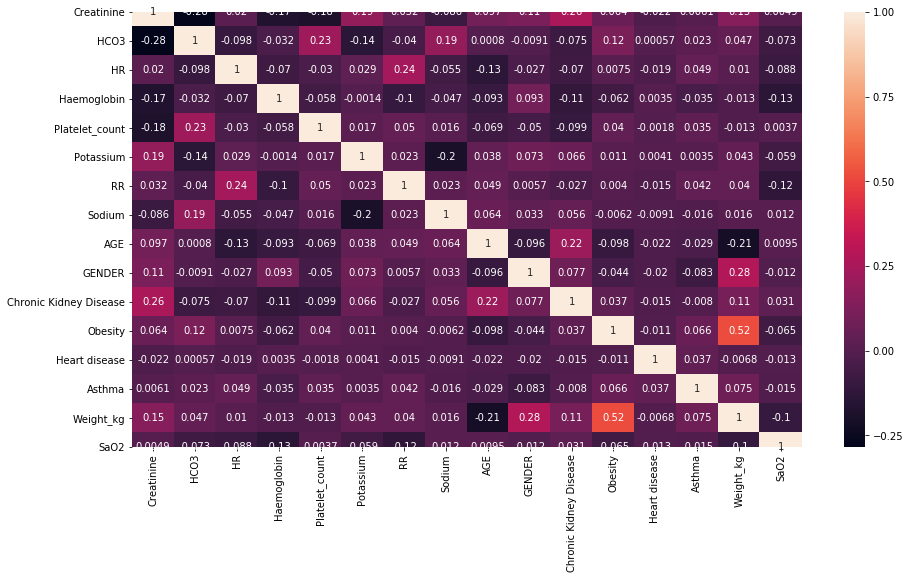

In [22]:
corrMatrix = df[X_cols].corr()

plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True)

### Create Model

Why 128 units?
Hypermarater search?
TODO

In [441]:
# units - dimensionality of output space from LSTM
lstm_units = 128

input_layer = Input(shape=(None, len(X_cols))) 

# set states going into this LSTM application
# in order to use SHAP, need to pass on state
feedin_previous_output = Input(shape=(lstm_units)) 
feedin_cell_state = Input(shape=(lstm_units)) 

x = Masking(mask_value=0)(input_layer)
x = LSTM(lstm_units, return_state=True)(x, initial_state=[feedin_previous_output, feedin_cell_state])

# get output from LSTM
output = Lambda(lambda x: x[0])(x)
output = Dense(1, activation='sigmoid')(output) # binary output

# as well as the model output, we want the hidden state output and the cell
# state for later. 
# See https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
lstm_output = Lambda(lambda x: x[0])(x)
cell_state = Lambda(lambda x: x[2])(x)

model = Model(inputs=[input_layer, feedin_previous_output, feedin_cell_state],
              outputs=[output, lstm_output, cell_state])


In [442]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
# only optimize output from dense layer
model.compile(optimizer, loss=['binary_crossentropy', None, None], metrics=['acc'])

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, None, 16)]   0                                            
__________________________________________________________________________________________________
masking_34 (Masking)            (None, None, 16)     0           input_49[0][0]                   
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 128)]        0                                            
___________________________________________________________________________________________

In [443]:
# default initial state is all zeros
zero = np.zeros((1,128))

In [444]:
output, lstm_output, cell_state = model.predict([lst_test[0].reshape(1,-1,len(X_cols)),zero,zero])
output

array([[0.35055625]], dtype=float32)

In [445]:
lst_test[0].reshape(1,-1,len(X_cols)).shape

(1, 6, 16)

In [446]:
output, lstm_output, cell_state = model.predict([lst_test[0][5].reshape(1,-1,len(X_cols)),zero,zero])
output

array([[0.39971456]], dtype=float32)

In [447]:
output, lstm_output, cell_state = model.predict([lst_test[0][:5].reshape(1,-1,len(X_cols)),zero,zero])
output

array([[0.36426538]], dtype=float32)

In [448]:
output, lstm_output, cell_state = model.predict([lst_test[0][5].reshape(1,-1,len(X_cols)),lstm_output, cell_state])
output

array([[0.35055625]], dtype=float32)

THEY MATCH!!!!

In [449]:
X_train.shape

(2312, 63, 16)

In [450]:
model.fit(x=[X_train, np.zeros((len(X_train), 128)), np.zeros((len(X_train), 128))],
          y=Y_train, class_weight=class_weight, epochs=70)

Epoch 1/70
73/73 [==============================] - ETA: 0s - loss: 0.9633 - dense_19_loss: 0.9633 - dense_19_acc: 0.5625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.8837 - dense_19_loss: 0.8837 - dense_19_acc: 0.6562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 2s - loss: 0.8590 - dense_19_loss: 0.8590 - dense_19_acc: 0.6938 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.8702 - dense_19_loss: 0.8702 - dense_19_acc: 0.6964 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.8665 - dense_19_loss: 0.8665 - dense_19_acc: 0.7014 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.8647 - dense_19_loss: 0.8647 - dense_19_acc: 0.6989 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.8521 - dense_19_loss: 0.8521 - dense_19_acc: 0.7019 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.8538 - dense_19_loss: 0.8538 - dense_19_acc: 0.6875 - lambda_40_acc:

73/73 [==============================] - ETA: 0s - loss: 0.7153 - dense_19_loss: 0.7153 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7889 - dense_19_loss: 0.7889 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7679 - dense_19_loss: 0.7679 - dense_19_acc: 0.7437 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7649 - dense_19_loss: 0.7649 - dense_19_acc: 0.7366 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7586 - dense_19_loss: 0.7586 - dense_19_acc: 0.7431 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7585 - dense_19_loss: 0.7585 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7544 - dense_19_loss: 0.7544 - dense_19_acc: 0.7380 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7627 - dense_19_loss: 0.7627 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5734 - dense_19_loss: 0.5734 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5520 - dense_19_loss: 0.5520 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6413 - dense_19_loss: 0.6413 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6685 - dense_19_loss: 0.6685 - dense_19_acc: 0.7902 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0045   - ETA: 1s - loss: 0.6780 - dense_19_loss: 0.6780 - dense_19_acc: 0.8056 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.7220 - dense_19_loss: 0.7220 - dense_19_acc: 0.7898 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.7176 - dense_19_loss: 0.7176 - dense_19_acc: 0.7909 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.7087 - dense_19_loss: 0.7087 - dense_19_acc: 0.7917 - lambda_40_acc: 0.

73/73 [==============================] - ETA: 0s - loss: 0.6537 - dense_19_loss: 0.6537 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7991 - dense_19_loss: 0.7991 - dense_19_acc: 0.6979 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.7515 - dense_19_loss: 0.7515 - dense_19_acc: 0.7312 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.7448 - dense_19_loss: 0.7448 - dense_19_acc: 0.7366 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.7099 - dense_19_loss: 0.7099 - dense_19_acc: 0.7431 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6926 - dense_19_loss: 0.6926 - dense_19_acc: 0.7614 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6913 - dense_19_loss: 0.6913 - dense_19_acc: 0.7644 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.7017 - dense_19_loss: 0.7017 - dense_19_acc: 0.7667 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4642 - dense_19_loss: 0.4642 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7141 - dense_19_loss: 0.7141 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7430 - dense_19_loss: 0.7430 - dense_19_acc: 0.7312 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.7708 - dense_19_loss: 0.7708 - dense_19_acc: 0.7098 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 2s - loss: 0.7286 - dense_19_loss: 0.7286 - dense_19_acc: 0.7396 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6973 - dense_19_loss: 0.6973 - dense_19_acc: 0.7642 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6904 - dense_19_loss: 0.6904 - dense_19_acc: 0.7620 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6911 - dense_19_loss: 0.6911 - dense_19_acc: 0.7583 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.6891 - dense_19_loss: 0.6891 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6096 - dense_19_loss: 0.6096 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.6390 - dense_19_loss: 0.6390 - dense_19_acc: 0.7563 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6380 - dense_19_loss: 0.6380 - dense_19_acc: 0.7768 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6446 - dense_19_loss: 0.6446 - dense_19_acc: 0.7639 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6147 - dense_19_loss: 0.6147 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6414 - dense_19_loss: 0.6414 - dense_19_acc: 0.7740 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6449 - dense_19_loss: 0.6449 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5970 - dense_19_loss: 0.5970 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6299 - dense_19_loss: 0.6299 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6291 - dense_19_loss: 0.6291 - dense_19_acc: 0.8000 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6082 - dense_19_loss: 0.6082 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0045   - ETA: 1s - loss: 0.6329 - dense_19_loss: 0.6329 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6412 - dense_19_loss: 0.6412 - dense_19_acc: 0.7727 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6397 - dense_19_loss: 0.6397 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6451 - dense_19_loss: 0.6451 - dense_19_acc: 0.7875 - lambda_40_acc: 0.

73/73 [==============================] - ETA: 0s - loss: 0.6047 - dense_19_loss: 0.6047 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.6752 - dense_19_loss: 0.6752 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6568 - dense_19_loss: 0.6568 - dense_19_acc: 0.8000 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6681 - dense_19_loss: 0.6681 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6278 - dense_19_loss: 0.6278 - dense_19_acc: 0.7986 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6180 - dense_19_loss: 0.6180 - dense_19_acc: 0.8011 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6117 - dense_19_loss: 0.6117 - dense_19_acc: 0.8077 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6014 - dense_19_loss: 0.6014 - dense_19_acc: 0.8167 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4930 - dense_19_loss: 0.4930 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5940 - dense_19_loss: 0.5940 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.6192 - dense_19_loss: 0.6192 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.5741 - dense_19_loss: 0.5741 - dense_19_acc: 0.8170 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.5900 - dense_19_loss: 0.5900 - dense_19_acc: 0.8160 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5731 - dense_19_loss: 0.5731 - dense_19_acc: 0.8267 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6106 - dense_19_loss: 0.6106 - dense_19_acc: 0.8077 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6281 - dense_19_loss: 0.6281 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5801 - dense_19_loss: 0.5801 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.5781 - dense_19_loss: 0.5781 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 2s - loss: 0.5415 - dense_19_loss: 0.5415 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6042 - dense_19_loss: 0.6042 - dense_19_acc: 0.7991 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.6112 - dense_19_loss: 0.6112 - dense_19_acc: 0.7986 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6199 - dense_19_loss: 0.6199 - dense_19_acc: 0.8040 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6066 - dense_19_loss: 0.6066 - dense_19_acc: 0.8149 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6102 - dense_19_loss: 0.6102 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4518 - dense_19_loss: 0.4518 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6647 - dense_19_loss: 0.6647 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6487 - dense_19_loss: 0.6487 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6863 - dense_19_loss: 0.6863 - dense_19_acc: 0.7723 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6768 - dense_19_loss: 0.6768 - dense_19_acc: 0.7847 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0035   - ETA: 1s - loss: 0.6596 - dense_19_loss: 0.6596 - dense_19_acc: 0.7898 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6400 - dense_19_loss: 0.6400 - dense_19_acc: 0.7909 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6381 - dense_19_loss: 0.6381 - dense_19_acc: 0.7771 - lambda_40_acc

73/73 [==============================] - ETA: 0s - loss: 0.9505 - dense_19_loss: 0.9505 - dense_19_acc: 0.6562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.6754 - dense_19_loss: 0.6754 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6245 - dense_19_loss: 0.6245 - dense_19_acc: 0.7375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.5975 - dense_19_loss: 0.5975 - dense_19_acc: 0.7768 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6069 - dense_19_loss: 0.6069 - dense_19_acc: 0.7778 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6086 - dense_19_loss: 0.6086 - dense_19_acc: 0.7841 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6170 - dense_19_loss: 0.6170 - dense_19_acc: 0.7764 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6136 - dense_19_loss: 0.6136 - dense_19_acc: 0.7792 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5702 - dense_19_loss: 0.5702 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5784 - dense_19_loss: 0.5784 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6665 - dense_19_loss: 0.6665 - dense_19_acc: 0.7625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6660 - dense_19_loss: 0.6660 - dense_19_acc: 0.7723 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 2s - loss: 0.6494 - dense_19_loss: 0.6494 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 2s - loss: 0.6493 - dense_19_loss: 0.6493 - dense_19_acc: 0.7983 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6150 - dense_19_loss: 0.6150 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6247 - dense_19_loss: 0.6247 - dense_19_acc: 0.8104 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.6320 - dense_19_loss: 0.6320 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5830 - dense_19_loss: 0.5830 - dense_19_acc: 0.8646 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.6077 - dense_19_loss: 0.6077 - dense_19_acc: 0.8625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5861 - dense_19_loss: 0.5861 - dense_19_acc: 0.8571 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5875 - dense_19_loss: 0.5875 - dense_19_acc: 0.8472 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5904 - dense_19_loss: 0.5904 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5979 - dense_19_loss: 0.5979 - dense_19_acc: 0.8245 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6019 - dense_19_loss: 0.6019 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.6054 - dense_19_loss: 0.6054 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5344 - dense_19_loss: 0.5344 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5440 - dense_19_loss: 0.5440 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5856 - dense_19_loss: 0.5856 - dense_19_acc: 0.7634 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6069 - dense_19_loss: 0.6069 - dense_19_acc: 0.7674 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5948 - dense_19_loss: 0.5948 - dense_19_acc: 0.7898 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6043 - dense_19_loss: 0.6043 - dense_19_acc: 0.7981 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5877 - dense_19_loss: 0.5877 - dense_19_acc: 0.8083 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.7219 - dense_19_loss: 0.7219 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.7115 - dense_19_loss: 0.7115 - dense_19_acc: 0.7396 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.6450 - dense_19_loss: 0.6450 - dense_19_acc: 0.7563 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6189 - dense_19_loss: 0.6189 - dense_19_acc: 0.7679 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6006 - dense_19_loss: 0.6006 - dense_19_acc: 0.7882 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.5952 - dense_19_loss: 0.5952 - dense_19_acc: 0.7898 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6416 - dense_19_loss: 0.6416 - dense_19_acc: 0.7837 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6344 - dense_19_loss: 0.6344 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.7126 - dense_19_loss: 0.7126 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5921 - dense_19_loss: 0.5921 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5602 - dense_19_loss: 0.5602 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0125   - ETA: 1s - loss: 0.5940 - dense_19_loss: 0.5940 - dense_19_acc: 0.7902 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6100 - dense_19_loss: 0.6100 - dense_19_acc: 0.7882 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6327 - dense_19_loss: 0.6327 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6218 - dense_19_loss: 0.6218 - dense_19_acc: 0.7620 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6108 - dense_19_loss: 0.6108 - dense_19_acc: 0.7667 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.5725 - dense_19_loss: 0.5725 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.6086 - dense_19_loss: 0.6086 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6139 - dense_19_loss: 0.6139 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5920 - dense_19_loss: 0.5920 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.5738 - dense_19_loss: 0.5738 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5560 - dense_19_loss: 0.5560 - dense_19_acc: 0.8295 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5228 - dense_19_loss: 0.5228 - dense_19_acc: 0.8462 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5555 - dense_19_loss: 0.5555 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.6464 - dense_19_loss: 0.6464 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.6148 - dense_19_loss: 0.6148 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6317 - dense_19_loss: 0.6317 - dense_19_acc: 0.8000 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5987 - dense_19_loss: 0.5987 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5783 - dense_19_loss: 0.5783 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5740 - dense_19_loss: 0.5740 - dense_19_acc: 0.8239 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5908 - dense_19_loss: 0.5908 - dense_19_acc: 0.8173 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6129 - dense_19_loss: 0.6129 - dense_19_acc: 0.8146 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4456 - dense_19_loss: 0.4456 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5019 - dense_19_loss: 0.5019 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0417   - ETA: 1s - loss: 0.5309 - dense_19_loss: 0.5309 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5325 - dense_19_loss: 0.5325 - dense_19_acc: 0.8170 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4964 - dense_19_loss: 0.4964 - dense_19_acc: 0.8403 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5070 - dense_19_loss: 0.5070 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5397 - dense_19_loss: 0.5397 - dense_19_acc: 0.8293 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5287 - dense_19_loss: 0.5287 - dense_19_acc: 0.8375 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.7723 - dense_19_loss: 0.7723 - dense_19_acc: 0.6875 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5883 - dense_19_loss: 0.5883 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5054 - dense_19_loss: 0.5054 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0188   - ETA: 2s - loss: 0.5170 - dense_19_loss: 0.5170 - dense_19_acc: 0.8571 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.5264 - dense_19_loss: 0.5264 - dense_19_acc: 0.8611 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5258 - dense_19_loss: 0.5258 - dense_19_acc: 0.8580 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5263 - dense_19_loss: 0.5263 - dense_19_acc: 0.8606 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5358 - dense_19_loss: 0.5358 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.7465 - dense_19_loss: 0.7465 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.6055 - dense_19_loss: 0.6055 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.5650 - dense_19_loss: 0.5650 - dense_19_acc: 0.8375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5900 - dense_19_loss: 0.5900 - dense_19_acc: 0.8348 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5575 - dense_19_loss: 0.5575 - dense_19_acc: 0.8507 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5723 - dense_19_loss: 0.5723 - dense_19_acc: 0.8381 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5739 - dense_19_loss: 0.5739 - dense_19_acc: 0.8341 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5717 - dense_19_loss: 0.5717 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5337 - dense_19_loss: 0.5337 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6229 - dense_19_loss: 0.6229 - dense_19_acc: 0.7604 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6232 - dense_19_loss: 0.6232 - dense_19_acc: 0.7875 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0063   - ETA: 2s - loss: 0.6204 - dense_19_loss: 0.6204 - dense_19_acc: 0.7902 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.6246 - dense_19_loss: 0.6246 - dense_19_acc: 0.7986 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.6119 - dense_19_loss: 0.6119 - dense_19_acc: 0.8040 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.5832 - dense_19_loss: 0.5832 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5858 - dense_19_loss: 0.5858 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.4441 - dense_19_loss: 0.4441 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5091 - dense_19_loss: 0.5091 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5673 - dense_19_loss: 0.5673 - dense_19_acc: 0.7375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5961 - dense_19_loss: 0.5961 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5678 - dense_19_loss: 0.5678 - dense_19_acc: 0.7778 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5460 - dense_19_loss: 0.5460 - dense_19_acc: 0.7983 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5585 - dense_19_loss: 0.5585 - dense_19_acc: 0.7837 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5694 - dense_19_loss: 0.5694 - dense_19_acc: 0.7875 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.3703 - dense_19_loss: 0.3703 - dense_19_acc: 0.9375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4293 - dense_19_loss: 0.4293 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.4071 - dense_19_loss: 0.4071 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4563 - dense_19_loss: 0.4563 - dense_19_acc: 0.8482 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4746 - dense_19_loss: 0.4746 - dense_19_acc: 0.8403 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5141 - dense_19_loss: 0.5141 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5294 - dense_19_loss: 0.5294 - dense_19_acc: 0.8293 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5509 - dense_19_loss: 0.5509 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.6199 - dense_19_loss: 0.6199 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5319 - dense_19_loss: 0.5319 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5108 - dense_19_loss: 0.5108 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4941 - dense_19_loss: 0.4941 - dense_19_acc: 0.8214 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5200 - dense_19_loss: 0.5200 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5144 - dense_19_loss: 0.5144 - dense_19_acc: 0.8267 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4950 - dense_19_loss: 0.4950 - dense_19_acc: 0.8389 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5333 - dense_19_loss: 0.5333 - dense_19_acc: 0.8250 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5342 - dense_19_loss: 0.5342 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5784 - dense_19_loss: 0.5784 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5567 - dense_19_loss: 0.5567 - dense_19_acc: 0.8000 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5677 - dense_19_loss: 0.5677 - dense_19_acc: 0.8036 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5590 - dense_19_loss: 0.5590 - dense_19_acc: 0.8090 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5763 - dense_19_loss: 0.5763 - dense_19_acc: 0.7955 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5843 - dense_19_loss: 0.5843 - dense_19_acc: 0.7981 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5840 - dense_19_loss: 0.5840 - dense_19_acc: 0.8042 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5126 - dense_19_loss: 0.5126 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5882 - dense_19_loss: 0.5882 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5838 - dense_19_loss: 0.5838 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6221 - dense_19_loss: 0.6221 - dense_19_acc: 0.7991 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6033 - dense_19_loss: 0.6033 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6212 - dense_19_loss: 0.6212 - dense_19_acc: 0.7955 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6065 - dense_19_loss: 0.6065 - dense_19_acc: 0.8005 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5866 - dense_19_loss: 0.5866 - dense_19_acc: 0.8000 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5957 - dense_19_loss: 0.5957 - dense_19_acc: 0.6562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5318 - dense_19_loss: 0.5318 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4973 - dense_19_loss: 0.4973 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5027 - dense_19_loss: 0.5027 - dense_19_acc: 0.8036 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4858 - dense_19_loss: 0.4858 - dense_19_acc: 0.8194 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5005 - dense_19_loss: 0.5005 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5001 - dense_19_loss: 0.5001 - dense_19_acc: 0.8197 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5237 - dense_19_loss: 0.5237 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4331 - dense_19_loss: 0.4331 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5349 - dense_19_loss: 0.5349 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4975 - dense_19_loss: 0.4975 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0125   - ETA: 1s - loss: 0.5032 - dense_19_loss: 0.5032 - dense_19_acc: 0.8214 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4918 - dense_19_loss: 0.4918 - dense_19_acc: 0.8368 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4974 - dense_19_loss: 0.4974 - dense_19_acc: 0.8409 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5069 - dense_19_loss: 0.5069 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5329 - dense_19_loss: 0.5329 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.4578 - dense_19_loss: 0.4578 - dense_19_acc: 0.9375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5755 - dense_19_loss: 0.5755 - dense_19_acc: 0.8646 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5883 - dense_19_loss: 0.5883 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 2s - loss: 0.6289 - dense_19_loss: 0.6289 - dense_19_acc: 0.8036 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 2s - loss: 0.6323 - dense_19_loss: 0.6323 - dense_19_acc: 0.7986 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 2s - loss: 0.6341 - dense_19_loss: 0.6341 - dense_19_acc: 0.7869 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6289 - dense_19_loss: 0.6289 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.6325 - dense_19_loss: 0.6325 - dense_19_acc: 0.7792 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5046 - dense_19_loss: 0.5046 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5985 - dense_19_loss: 0.5985 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5603 - dense_19_loss: 0.5603 - dense_19_acc: 0.7875 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0063   - ETA: 1s - loss: 0.5766 - dense_19_loss: 0.5766 - dense_19_acc: 0.7768 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5985 - dense_19_loss: 0.5985 - dense_19_acc: 0.7639 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6123 - dense_19_loss: 0.6123 - dense_19_acc: 0.7727 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5951 - dense_19_loss: 0.5951 - dense_19_acc: 0.7837 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6165 - dense_19_loss: 0.6165 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.6260 - dense_19_loss: 0.6260 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5440 - dense_19_loss: 0.5440 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.4979 - dense_19_loss: 0.4979 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5107 - dense_19_loss: 0.5107 - dense_19_acc: 0.8705 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5372 - dense_19_loss: 0.5372 - dense_19_acc: 0.8403 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5464 - dense_19_loss: 0.5464 - dense_19_acc: 0.8295 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5733 - dense_19_loss: 0.5733 - dense_19_acc: 0.8149 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5683 - dense_19_loss: 0.5683 - dense_19_acc: 0.8146 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5785 - dense_19_loss: 0.5785 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5553 - dense_19_loss: 0.5553 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0208   - ETA: 1s - loss: 0.5087 - dense_19_loss: 0.5087 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4937 - dense_19_loss: 0.4937 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4956 - dense_19_loss: 0.4956 - dense_19_acc: 0.8368 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4802 - dense_19_loss: 0.4802 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4913 - dense_19_loss: 0.4913 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4910 - dense_19_loss: 0.4910 - dense_19_acc: 0.8417 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4870 - dense_19_loss: 0.4870 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5426 - dense_19_loss: 0.5426 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0208   - ETA: 1s - loss: 0.5637 - dense_19_loss: 0.5637 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5944 - dense_19_loss: 0.5944 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5762 - dense_19_loss: 0.5762 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5758 - dense_19_loss: 0.5758 - dense_19_acc: 0.8153 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5943 - dense_19_loss: 0.5943 - dense_19_acc: 0.8077 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5766 - dense_19_loss: 0.5766 - dense_19_acc: 0.8146 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4363 - dense_19_loss: 0.4363 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5599 - dense_19_loss: 0.5599 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5195 - dense_19_loss: 0.5195 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0063   - ETA: 1s - loss: 0.5378 - dense_19_loss: 0.5378 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5392 - dense_19_loss: 0.5392 - dense_19_acc: 0.8194 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5449 - dense_19_loss: 0.5449 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5405 - dense_19_loss: 0.5405 - dense_19_acc: 0.8221 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5297 - dense_19_loss: 0.5297 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.4536 - dense_19_loss: 0.4536 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5790 - dense_19_loss: 0.5790 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5331 - dense_19_loss: 0.5331 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0125   - ETA: 1s - loss: 0.5390 - dense_19_loss: 0.5390 - dense_19_acc: 0.8304 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5514 - dense_19_loss: 0.5514 - dense_19_acc: 0.8403 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5321 - dense_19_loss: 0.5321 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5293 - dense_19_loss: 0.5293 - dense_19_acc: 0.8413 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5098 - dense_19_loss: 0.5098 - dense_19_acc: 0.8521 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.9075 - dense_19_loss: 0.9075 - dense_19_acc: 0.6562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.6572 - dense_19_loss: 0.6572 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5860 - dense_19_loss: 0.5860 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6191 - dense_19_loss: 0.6191 - dense_19_acc: 0.8036 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.6209 - dense_19_loss: 0.6209 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6277 - dense_19_loss: 0.6277 - dense_19_acc: 0.7642 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6219 - dense_19_loss: 0.6219 - dense_19_acc: 0.7692 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6099 - dense_19_loss: 0.6099 - dense_19_acc: 0.7792 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5264 - dense_19_loss: 0.5264 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4738 - dense_19_loss: 0.4738 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0208   - ETA: 1s - loss: 0.4863 - dense_19_loss: 0.4863 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5013 - dense_19_loss: 0.5013 - dense_19_acc: 0.8393 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5349 - dense_19_loss: 0.5349 - dense_19_acc: 0.8264 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5202 - dense_19_loss: 0.5202 - dense_19_acc: 0.8295 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5090 - dense_19_loss: 0.5090 - dense_19_acc: 0.8389 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5163 - dense_19_loss: 0.5163 - dense_19_acc: 0.8354 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.2600 - dense_19_loss: 0.2600 - dense_19_acc: 0.9688 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4632 - dense_19_loss: 0.4632 - dense_19_acc: 0.8854 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4847 - dense_19_loss: 0.4847 - dense_19_acc: 0.8625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5010 - dense_19_loss: 0.5010 - dense_19_acc: 0.8571 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 2s - loss: 0.5078 - dense_19_loss: 0.5078 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5063 - dense_19_loss: 0.5063 - dense_19_acc: 0.8466 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5188 - dense_19_loss: 0.5188 - dense_19_acc: 0.8486 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5092 - dense_19_loss: 0.5092 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.6020 - dense_19_loss: 0.6020 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5030 - dense_19_loss: 0.5030 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6388 - dense_19_loss: 0.6388 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5984 - dense_19_loss: 0.5984 - dense_19_acc: 0.8036 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5837 - dense_19_loss: 0.5837 - dense_19_acc: 0.8090 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5919 - dense_19_loss: 0.5919 - dense_19_acc: 0.8068 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5664 - dense_19_loss: 0.5664 - dense_19_acc: 0.8197 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5559 - dense_19_loss: 0.5559 - dense_19_acc: 0.8250 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5027 - dense_19_loss: 0.5027 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5880 - dense_19_loss: 0.5880 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5436 - dense_19_loss: 0.5436 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5388 - dense_19_loss: 0.5388 - dense_19_acc: 0.8214 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0045   - ETA: 1s - loss: 0.5062 - dense_19_loss: 0.5062 - dense_19_acc: 0.8472 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4814 - dense_19_loss: 0.4814 - dense_19_acc: 0.8494 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4861 - dense_19_loss: 0.4861 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5107 - dense_19_loss: 0.5107 - dense_19_acc: 0.8375 - lambda_40_acc: 0.

73/73 [==============================] - ETA: 0s - loss: 0.5794 - dense_19_loss: 0.5794 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5617 - dense_19_loss: 0.5617 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5301 - dense_19_loss: 0.5301 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0125   - ETA: 1s - loss: 0.5597 - dense_19_loss: 0.5597 - dense_19_acc: 0.7902 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5363 - dense_19_loss: 0.5363 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5432 - dense_19_loss: 0.5432 - dense_19_acc: 0.8011 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5430 - dense_19_loss: 0.5430 - dense_19_acc: 0.8053 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5553 - dense_19_loss: 0.5553 - dense_19_acc: 0.8104 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.3550 - dense_19_loss: 0.3550 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4798 - dense_19_loss: 0.4798 - dense_19_acc: 0.8958 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5097 - dense_19_loss: 0.5097 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4891 - dense_19_loss: 0.4891 - dense_19_acc: 0.8527 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4867 - dense_19_loss: 0.4867 - dense_19_acc: 0.8611 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5136 - dense_19_loss: 0.5136 - dense_19_acc: 0.8494 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4937 - dense_19_loss: 0.4937 - dense_19_acc: 0.8462 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5044 - dense_19_loss: 0.5044 - dense_19_acc: 0.8354 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4796 - dense_19_loss: 0.4796 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5206 - dense_19_loss: 0.5206 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5679 - dense_19_loss: 0.5679 - dense_19_acc: 0.7875 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5263 - dense_19_loss: 0.5263 - dense_19_acc: 0.8080 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5105 - dense_19_loss: 0.5105 - dense_19_acc: 0.8160 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5078 - dense_19_loss: 0.5078 - dense_19_acc: 0.8267 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5201 - dense_19_loss: 0.5201 - dense_19_acc: 0.8221 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4961 - dense_19_loss: 0.4961 - dense_19_acc: 0.8354 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.6819 - dense_19_loss: 0.6819 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5221 - dense_19_loss: 0.5221 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.4668 - dense_19_loss: 0.4668 - dense_19_acc: 0.8625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4960 - dense_19_loss: 0.4960 - dense_19_acc: 0.8393 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4881 - dense_19_loss: 0.4881 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4969 - dense_19_loss: 0.4969 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4832 - dense_19_loss: 0.4832 - dense_19_acc: 0.8462 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4650 - dense_19_loss: 0.4650 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.5971 - dense_19_loss: 0.5971 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4866 - dense_19_loss: 0.4866 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5639 - dense_19_loss: 0.5639 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5566 - dense_19_loss: 0.5566 - dense_19_acc: 0.8304 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5523 - dense_19_loss: 0.5523 - dense_19_acc: 0.8194 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5709 - dense_19_loss: 0.5709 - dense_19_acc: 0.8040 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5609 - dense_19_loss: 0.5609 - dense_19_acc: 0.8077 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5551 - dense_19_loss: 0.5551 - dense_19_acc: 0.8083 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4914 - dense_19_loss: 0.4914 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.4969 - dense_19_loss: 0.4969 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4872 - dense_19_loss: 0.4872 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4970 - dense_19_loss: 0.4970 - dense_19_acc: 0.8705 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 2s - loss: 0.4896 - dense_19_loss: 0.4896 - dense_19_acc: 0.8681 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5039 - dense_19_loss: 0.5039 - dense_19_acc: 0.8580 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5126 - dense_19_loss: 0.5126 - dense_19_acc: 0.8534 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5131 - dense_19_loss: 0.5131 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4870 - dense_19_loss: 0.4870 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4204 - dense_19_loss: 0.4204 - dense_19_acc: 0.8958 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5384 - dense_19_loss: 0.5384 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5342 - dense_19_loss: 0.5342 - dense_19_acc: 0.8348 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0089   - ETA: 1s - loss: 0.5315 - dense_19_loss: 0.5315 - dense_19_acc: 0.8299 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5227 - dense_19_loss: 0.5227 - dense_19_acc: 0.8267 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5173 - dense_19_loss: 0.5173 - dense_19_acc: 0.8245 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5126 - dense_19_loss: 0.5126 - dense_19_acc: 0.8229 - lambda_40_acc: 0.

73/73 [==============================] - ETA: 0s - loss: 0.6566 - dense_19_loss: 0.6566 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5404 - dense_19_loss: 0.5404 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5687 - dense_19_loss: 0.5687 - dense_19_acc: 0.7937 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0250   - ETA: 1s - loss: 0.5945 - dense_19_loss: 0.5945 - dense_19_acc: 0.7679 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5742 - dense_19_loss: 0.5742 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5493 - dense_19_loss: 0.5493 - dense_19_acc: 0.8068 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5725 - dense_19_loss: 0.5725 - dense_19_acc: 0.8005 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5676 - dense_19_loss: 0.5676 - dense_19_acc: 0.8042 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.5881 - dense_19_loss: 0.5881 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5704 - dense_19_loss: 0.5704 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.6077 - dense_19_loss: 0.6077 - dense_19_acc: 0.7625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.6186 - dense_19_loss: 0.6186 - dense_19_acc: 0.7545 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5887 - dense_19_loss: 0.5887 - dense_19_acc: 0.7743 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5565 - dense_19_loss: 0.5565 - dense_19_acc: 0.7869 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5520 - dense_19_loss: 0.5520 - dense_19_acc: 0.8005 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5439 - dense_19_loss: 0.5439 - dense_19_acc: 0.8146 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4088 - dense_19_loss: 0.4088 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5065 - dense_19_loss: 0.5065 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4869 - dense_19_loss: 0.4869 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0250   - ETA: 1s - loss: 0.4729 - dense_19_loss: 0.4729 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4547 - dense_19_loss: 0.4547 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4596 - dense_19_loss: 0.4596 - dense_19_acc: 0.8551 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4857 - dense_19_loss: 0.4857 - dense_19_acc: 0.8510 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4962 - dense_19_loss: 0.4962 - dense_19_acc: 0.8458 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.5966 - dense_19_loss: 0.5966 - dense_19_acc: 0.7188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5766 - dense_19_loss: 0.5766 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.5799 - dense_19_loss: 0.5799 - dense_19_acc: 0.7688 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5718 - dense_19_loss: 0.5718 - dense_19_acc: 0.7991 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5625 - dense_19_loss: 0.5625 - dense_19_acc: 0.8056 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5526 - dense_19_loss: 0.5526 - dense_19_acc: 0.8153 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5258 - dense_19_loss: 0.5258 - dense_19_acc: 0.8317 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5210 - dense_19_loss: 0.5210 - dense_19_acc: 0.8354 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4306 - dense_19_loss: 0.4306 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.06 - ETA: 1s - loss: 0.4641 - dense_19_loss: 0.4641 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4822 - dense_19_loss: 0.4822 - dense_19_acc: 0.8313 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4681 - dense_19_loss: 0.4681 - dense_19_acc: 0.8527 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4998 - dense_19_loss: 0.4998 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5221 - dense_19_loss: 0.5221 - dense_19_acc: 0.8182 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5177 - dense_19_loss: 0.5177 - dense_19_acc: 0.8221 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5111 - dense_19_loss: 0.5111 - dense_19_acc: 0.8271 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4755 - dense_19_loss: 0.4755 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5223 - dense_19_loss: 0.5223 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0208   - ETA: 1s - loss: 0.5588 - dense_19_loss: 0.5588 - dense_19_acc: 0.8375 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6024 - dense_19_loss: 0.6024 - dense_19_acc: 0.8170 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.6223 - dense_19_loss: 0.6223 - dense_19_acc: 0.8160 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5997 - dense_19_loss: 0.5997 - dense_19_acc: 0.8153 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5981 - dense_19_loss: 0.5981 - dense_19_acc: 0.7981 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5877 - dense_19_loss: 0.5877 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4715 - dense_19_loss: 0.4715 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4304 - dense_19_loss: 0.4304 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4740 - dense_19_loss: 0.4740 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4736 - dense_19_loss: 0.4736 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4796 - dense_19_loss: 0.4796 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4835 - dense_19_loss: 0.4835 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4945 - dense_19_loss: 0.4945 - dense_19_acc: 0.8606 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4931 - dense_19_loss: 0.4931 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5147 - dense_19_loss: 0.5147 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5897 - dense_19_loss: 0.5897 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5782 - dense_19_loss: 0.5782 - dense_19_acc: 0.7750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0125   - ETA: 1s - loss: 0.5443 - dense_19_loss: 0.5443 - dense_19_acc: 0.7857 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5473 - dense_19_loss: 0.5473 - dense_19_acc: 0.7951 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5405 - dense_19_loss: 0.5405 - dense_19_acc: 0.7955 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5317 - dense_19_loss: 0.5317 - dense_19_acc: 0.8101 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5497 - dense_19_loss: 0.5497 - dense_19_acc: 0.8042 - lambda_40_acc: 0.0000

73/73 [==============================] - ETA: 0s - loss: 0.2913 - dense_19_loss: 0.2913 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4355 - dense_19_loss: 0.4355 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4498 - dense_19_loss: 0.4498 - dense_19_acc: 0.8625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5514 - dense_19_loss: 0.5514 - dense_19_acc: 0.8304 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5532 - dense_19_loss: 0.5532 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5401 - dense_19_loss: 0.5401 - dense_19_acc: 0.8210 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5497 - dense_19_loss: 0.5497 - dense_19_acc: 0.8077 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5451 - dense_19_loss: 0.5451 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4210 - dense_19_loss: 0.4210 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4725 - dense_19_loss: 0.4725 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0104   - ETA: 1s - loss: 0.5156 - dense_19_loss: 0.5156 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5088 - dense_19_loss: 0.5088 - dense_19_acc: 0.8304 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5261 - dense_19_loss: 0.5261 - dense_19_acc: 0.8299 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5294 - dense_19_loss: 0.5294 - dense_19_acc: 0.8267 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5156 - dense_19_loss: 0.5156 - dense_19_acc: 0.8389 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5162 - dense_19_loss: 0.5162 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.7316 - dense_19_loss: 0.7316 - dense_19_acc: 0.7500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.6380 - dense_19_loss: 0.6380 - dense_19_acc: 0.7708 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5372 - dense_19_loss: 0.5372 - dense_19_acc: 0.8062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5094 - dense_19_loss: 0.5094 - dense_19_acc: 0.8348 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4841 - dense_19_loss: 0.4841 - dense_19_acc: 0.8507 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.5121 - dense_19_loss: 0.5121 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4928 - dense_19_loss: 0.4928 - dense_19_acc: 0.8534 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.00 - ETA: 1s - loss: 0.4938 - dense_19_loss: 0.4938 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5589 - dense_19_loss: 0.5589 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.6630 - dense_19_loss: 0.6630 - dense_19_acc: 0.8021 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0208   - ETA: 1s - loss: 0.6143 - dense_19_loss: 0.6143 - dense_19_acc: 0.8250 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5526 - dense_19_loss: 0.5526 - dense_19_acc: 0.8393 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5481 - dense_19_loss: 0.5481 - dense_19_acc: 0.8368 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5216 - dense_19_loss: 0.5216 - dense_19_acc: 0.8409 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5273 - dense_19_loss: 0.5273 - dense_19_acc: 0.8462 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5350 - dense_19_loss: 0.5350 - dense_19_acc: 0.8417 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4134 - dense_19_loss: 0.4134 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.3950 - dense_19_loss: 0.3950 - dense_19_acc: 0.9167 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.3889 - dense_19_loss: 0.3889 - dense_19_acc: 0.9125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.05 - ETA: 1s - loss: 0.4026 - dense_19_loss: 0.4026 - dense_19_acc: 0.9018 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.4170 - dense_19_loss: 0.4170 - dense_19_acc: 0.8889 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.4459 - dense_19_loss: 0.4459 - dense_19_acc: 0.8864 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4318 - dense_19_loss: 0.4318 - dense_19_acc: 0.8846 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4391 - dense_19_loss: 0.4391 - dense_19_acc: 0.8813 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4431 - dense_19_loss: 0.4431 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4749 - dense_19_loss: 0.4749 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4412 - dense_19_loss: 0.4412 - dense_19_acc: 0.8687 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.4908 - dense_19_loss: 0.4908 - dense_19_acc: 0.8482 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4805 - dense_19_loss: 0.4805 - dense_19_acc: 0.8507 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4634 - dense_19_loss: 0.4634 - dense_19_acc: 0.8693 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4914 - dense_19_loss: 0.4914 - dense_19_acc: 0.8582 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4905 - dense_19_loss: 0.4905 - dense_19_acc: 0.8667 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.4145 - dense_19_loss: 0.4145 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.3946 - dense_19_loss: 0.3946 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4545 - dense_19_loss: 0.4545 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4748 - dense_19_loss: 0.4748 - dense_19_acc: 0.8259 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4434 - dense_19_loss: 0.4434 - dense_19_acc: 0.8472 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4600 - dense_19_loss: 0.4600 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4676 - dense_19_loss: 0.4676 - dense_19_acc: 0.8462 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4586 - dense_19_loss: 0.4586 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5701 - dense_19_loss: 0.5701 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.4858 - dense_19_loss: 0.4858 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0417   - ETA: 1s - loss: 0.4790 - dense_19_loss: 0.4790 - dense_19_acc: 0.8625 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5154 - dense_19_loss: 0.5154 - dense_19_acc: 0.8527 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5114 - dense_19_loss: 0.5114 - dense_19_acc: 0.8472 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5070 - dense_19_loss: 0.5070 - dense_19_acc: 0.8494 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.4954 - dense_19_loss: 0.4954 - dense_19_acc: 0.8534 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5063 - dense_19_loss: 0.5063 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4905 - dense_19_loss: 0.4905 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0000e+ - ETA: 1s - loss: 0.5922 - dense_19_loss: 0.5922 - dense_19_acc: 0.7917 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.0312   - ETA: 1s - loss: 0.5744 - dense_19_loss: 0.5744 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5535 - dense_19_loss: 0.5535 - dense_19_acc: 0.8393 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.01 - ETA: 1s - loss: 0.5431 - dense_19_loss: 0.5431 - dense_19_acc: 0.8403 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5367 - dense_19_loss: 0.5367 - dense_19_acc: 0.8409 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5260 - dense_19_loss: 0.5260 - dense_19_acc: 0.8365 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5234 - dense_19_loss: 0.5234 - dense_19_acc: 0.8396 - lambda_40_acc: 0.0000e+00

73/73 [==============================] - ETA: 0s - loss: 0.4301 - dense_19_loss: 0.4301 - dense_19_acc: 0.9062 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5891 - dense_19_loss: 0.5891 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5971 - dense_19_loss: 0.5971 - dense_19_acc: 0.8188 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.5487 - dense_19_loss: 0.5487 - dense_19_acc: 0.8348 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.04 - ETA: 1s - loss: 0.5104 - dense_19_loss: 0.5104 - dense_19_acc: 0.8542 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4957 - dense_19_loss: 0.4957 - dense_19_acc: 0.8608 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4992 - dense_19_loss: 0.4992 - dense_19_acc: 0.8534 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5190 - dense_19_loss: 0.5190 - dense_19_acc: 0.8417 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.2657 - dense_19_loss: 0.2657 - dense_19_acc: 0.9688 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4878 - dense_19_loss: 0.4878 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.4993 - dense_19_loss: 0.4993 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.02 - ETA: 1s - loss: 0.5826 - dense_19_loss: 0.5826 - dense_19_acc: 0.8482 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5422 - dense_19_loss: 0.5422 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5563 - dense_19_loss: 0.5563 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5327 - dense_19_loss: 0.5327 - dense_19_acc: 0.8389 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.03 - ETA: 1s - loss: 0.5192 - dense_19_loss: 0.5192 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5081 - dense_19_loss: 0.5081 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.31 - ETA: 1s - loss: 0.5758 - dense_19_loss: 0.5758 - dense_19_acc: 0.8229 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.21 - ETA: 1s - loss: 0.5317 - dense_19_loss: 0.5317 - dense_19_acc: 0.8500 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.20 - ETA: 1s - loss: 0.5352 - dense_19_loss: 0.5352 - dense_19_acc: 0.8482 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.20 - ETA: 1s - loss: 0.5576 - dense_19_loss: 0.5576 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.21 - ETA: 1s - loss: 0.5601 - dense_19_loss: 0.5601 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.23 - ETA: 1s - loss: 0.5784 - dense_19_loss: 0.5784 - dense_19_acc: 0.8149 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.23 - ETA: 1s - loss: 0.5743 - dense_19_loss: 0.5743 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambd

73/73 [==============================] - ETA: 0s - loss: 0.5510 - dense_19_loss: 0.5510 - dense_19_acc: 0.7812 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.12 - ETA: 1s - loss: 0.5155 - dense_19_loss: 0.5155 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.20 - ETA: 1s - loss: 0.4948 - dense_19_loss: 0.4948 - dense_19_acc: 0.8562 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.25 - ETA: 1s - loss: 0.4891 - dense_19_loss: 0.4891 - dense_19_acc: 0.8438 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.26 - ETA: 1s - loss: 0.4934 - dense_19_loss: 0.4934 - dense_19_acc: 0.8368 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.24 - ETA: 1s - loss: 0.5043 - dense_19_loss: 0.5043 - dense_19_acc: 0.8352 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.23 - ETA: 1s - loss: 0.5180 - dense_19_loss: 0.5180 - dense_19_acc: 0.8389 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.23 - ETA: 1s - loss: 0.5130 - dense_19_loss: 0.5130 - dense_19_acc: 0.8375 - lambda_40_acc: 0.0000e+00 - lambd

In [451]:
model.evaluate(x=[X_train, np.zeros((len(X_train), 128)), np.zeros((len(X_train), 128))], y=Y_train)

73/73 [==============================] - ETA: 0s - loss: 0.3103 - dense_19_loss: 0.3103 - dense_19_acc: 0.8750 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.25 - ETA: 0s - loss: 0.3462 - dense_19_loss: 0.3462 - dense_19_acc: 0.8333 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.22 - ETA: 0s - loss: 0.3638 - dense_19_loss: 0.3638 - dense_19_acc: 0.8210 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.24 - ETA: 0s - loss: 0.3881 - dense_19_loss: 0.3881 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.25 - ETA: 0s - loss: 0.3861 - dense_19_loss: 0.3861 - dense_19_acc: 0.8224 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.24 - ETA: 0s - loss: 0.3914 - dense_19_loss: 0.3914 - dense_19_acc: 0.8261 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.24 - ETA: 0s - loss: 0.3935 - dense_19_loss: 0.3935 - dense_19_acc: 0.8252 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.24 - ETA: 0s - loss: 0.3904 - dense_19_loss: 0.3904 - dense_19_acc: 0.8256 - lambda_40_acc: 0.0000e+00 - lambd

[0.38919079303741455,
 0.38919079303741455,
 0.8300173282623291,
 0.0,
 0.26211073994636536]

In [452]:
model.evaluate(x=[X_test, np.zeros((len(X_test), 128)), np.zeros((len(X_test), 128))], y=Y_test)

19/19 [==============================] - ETA: 0s - loss: 0.5202 - dense_19_loss: 0.5202 - dense_19_acc: 0.8125 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.18 - ETA: 0s - loss: 0.3951 - dense_19_loss: 0.3951 - dense_19_acc: 0.8482 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.32 - ETA: 0s - loss: 0.4001 - dense_19_loss: 0.4001 - dense_19_acc: 0.8341 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.30 - ETA: 0s - loss: 0.3892 - dense_19_loss: 0.3892 - dense_19_acc: 0.8423 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.30 - 0s 9ms/step - loss: 0.3892 - dense_19_loss: 0.3892 - dense_19_acc: 0.8423 - lambda_40_acc: 0.0000e+00 - lambda_41_acc: 0.3050


[0.38922005891799927,
 0.38922005891799927,
 0.8422877192497253,
 0.0,
 0.30502599477767944]

In [453]:
# AUC
res = model.predict(x=X_test)[:,0]
argsort = np.argsort(res)

roc_auc_score(Y_test[argsort], res[argsort])

AssertionError: in user code:

    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    C:\Users\2gare\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\network.py:899 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("dense_19/Identity:0", shape=(None, 1), dtype=float32)


In [129]:
print(classification_report(Y_test[argsort], np.rint(res[argsort]).astype(int)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       408
           1       0.79      0.78      0.78       169

    accuracy                           0.87       577
   macro avg       0.85      0.85      0.85       577
weighted avg       0.87      0.87      0.87       577



how good is it?:
compare random forest with only admission data
can also do LSTM for this

## Missclassified results

In [30]:
argsort = np.argsort(Y_test)
Y_test[argsort[::-1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
preds = model.predict(x=X_test)
np.rint(preds).astype(int)[:,0][argsort[::-1]]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

# Plot accuracy vs increasing sequence length (from 0)

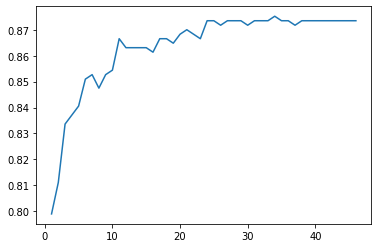

In [32]:
maxseqlen_test = max(len(lst) for lst in lst_test)
x = list(range(1,maxseqlen_test))
y = [model.evaluate(x=X_test[:,:a,:], y=Y_test, verbose=False)[1] for a in x]

sns.lineplot(x=x, y=y)

# Plot accuracy vs increasing sequence length (from end)
Is the model using anything more than the previous days data to predict death? 
If the accuracy increases when using more data from the end we can assume so.

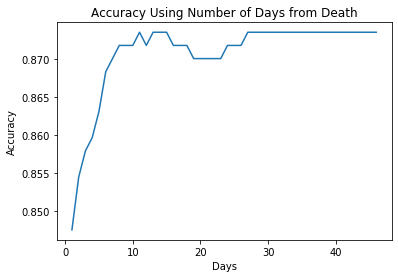

In [33]:
x = list(range(1,maxseqlen_test))
y = []

arr = np.zeros(X_test.shape)

for length in x:
    
    for index, point in enumerate(lst_test):
        r = np.array(point[::-1][:length][::-1])
        arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model.evaluate(x=arr, y=Y_test, verbose=False)[1])
    
fig = sns.lineplot(x=x, y=y)
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.show(fig)

# Misclassified stats

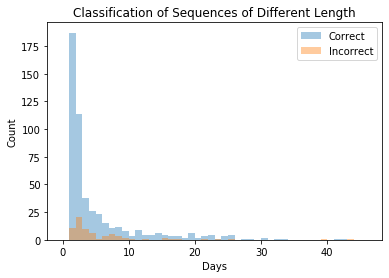

In [38]:
correct = []
incorrect = []

for index in range(len(lst_test)):
    result = model.predict(x=np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        correct.append(len(lst_test[index]))
    else:
        incorrect.append(len(lst_test[index]))

sns.distplot(correct, kde=False, bins=range(max(*correct, *incorrect)), label="Correct")
fig = sns.distplot(incorrect, kde=False, bins=range(max(*correct, *incorrect)), label="Incorrect")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

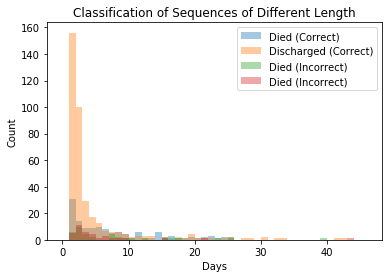

In [39]:
correct = {'Died':[], 'Discharged':[]}
incorrect = {'Died':[], 'Discharged':[]}

for index in range(len(lst_test)):
    result = model.predict(x=np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        if Y_test[index] == 0:
            correct['Discharged'].append(len(lst_test[index]))
        else:
            correct['Died'].append(len(lst_test[index]))
    else:
        if Y_test[index] == 0:
            incorrect['Discharged'].append(len(lst_test[index]))
        else:
            incorrect['Died'].append(len(lst_test[index]))
            
bins = range(max([y for x in list(correct.values()) + list(incorrect.values()) for y in x]))
            
sns.distplot(correct['Died'], kde=False, bins=bins, label="Died (Correct)")
sns.distplot(correct['Discharged'], kde=False, bins=bins, label="Discharged (Correct)")
sns.distplot(incorrect['Died'], kde=False, bins=bins, label="Died (Incorrect)")
fig = sns.distplot(incorrect['Discharged'], kde=False, bins=bins, label="Died (Incorrect)")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

In [40]:
..

SyntaxError: invalid syntax (<ipython-input-40-3d80792ead7e>, line 1)

In [155]:
# optional - save model
model.save('saved_models/BinaryDeath_random_873', overwrite=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/BinaryDeath_random_873\assets


In [161]:
# optional - load
model = keras.models.load_model('saved_models/BinaryDeath_random_873')

interesting thought - mask individual features?

should add comorbidities

# SHAP

Import a local version of shap in order to change a default setting for force plots. This is optional.

In [41]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [42]:
def predict(X):
    # use all daily data as if they're completely independent.
    X = X.reshape((-1,1,len(X_cols)))
    return model.predict(X).flatten()

In [43]:
all_data_summary = shap.kmeans(df_test[X_cols], 10)

In [44]:
%%time
input_data = df_test[X_cols]
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(input_data)


Wall time: 28min 19s


High SHAP values -> influenced the model towards death. E.g. High age and heart rate is associated with dying.

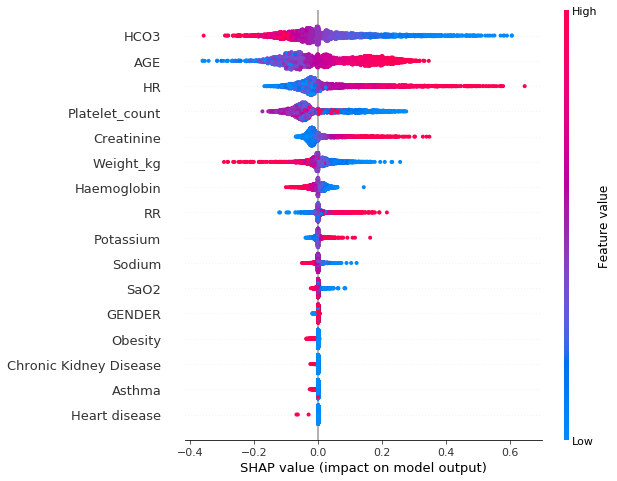

In [45]:
shap.summary_plot(shap_values, input_data)

The below shows a plot of age against the SHAP value. We can see that the age of around 65 has no effect on the model, in this case it is the average value. We also see how a high age always increases death chance, and a low age always decreases. However, this is not always the case. e.g. Heart rate can be too low or too high which will increase the shap value.

Bonus - try changing internaction_index

In [145]:
df_test['AGE'].mean()

65.58298171589311

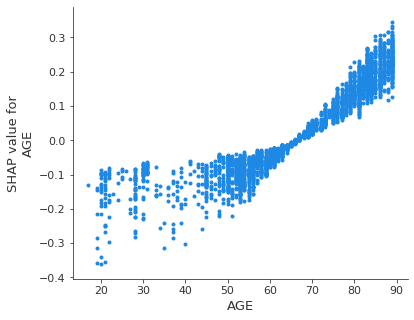

In [146]:
shap.dependence_plot('AGE', shap_values, features=input_data, interaction_index=None)

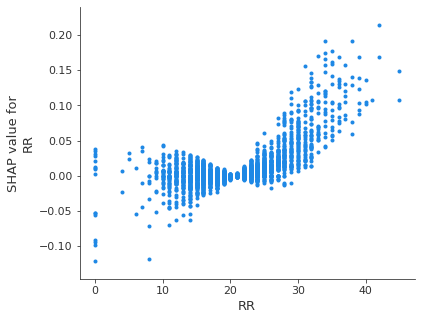

In [147]:
shap.dependence_plot('RR', shap_values, features=input_data, interaction_index=None)

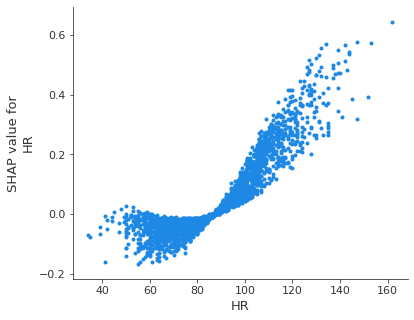

In [138]:
shap.dependence_plot('HR', shap_values, features=input_data, interaction_index=None)

## Look at evolution for an entire sequence
We can use a force plot to see how the SHAP scores change through a patients stay.

However, it's important to note that the model from SHAP only uses data from a single day.

In [150]:
seq = [0] + list(map(len, lst_test))
for i in range(len(seq)):
    if i != 0:
        seq[i] += seq[i-1]

longest_sequences_index = list(reversed(np.argsort([len(x) for x in lst_test])))

In [153]:
index = longest_sequences_index[17]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

Sequence length: 24
Predicted 0.9981037378311157, Actual 1


We wish to see what difference the single day data makes on the models confidence throughout the stay.

Text(0.5, 0, 'Days')

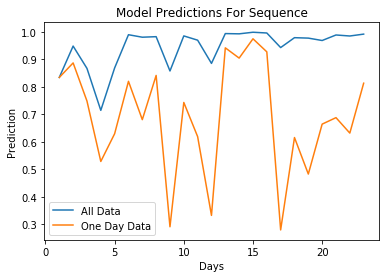

In [154]:
my_arr = lst_test[index]
x = range(1,len(my_arr))

all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in x]
single_day = [my_arr[i-1:i].reshape((1,-1,len(X_cols))) for i in x]

all_data = np.array([model.predict(x) for x in all_data]).reshape(-1)
single_day = np.array([model.predict(x) for x in single_day]).reshape(-1)

sns.lineplot(x=x, y=all_data, label="All Data")
sns.lineplot(x=x, y=single_day, label="One Day Data")
plt.legend()
plt.title('Model Predictions For Sequence')
plt.ylabel('Prediction')
plt.xlabel('Days')

In [51]:
index = 8
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [52]:
index = 12
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [53]:
shap.force_plot(explainer.expected_value, shap_values, input_data)

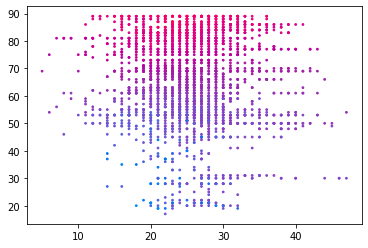

In [133]:
import matplotlib.pyplot as pl
from shap.plots import colors 

pl.scatter(input_data['HR'], input_data['AGE'], s=3,
           c=shap_values[:, X_cols.index('AGE')], cmap=colors.red_blue)